In [1]:
# Install necessary libraries
!pip install pandas matplotlib seaborn scikit-learn

In [2]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set the style for seaborn
sns.set(style="whitegrid")

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

In [4]:
import os
import json
import pandas as pd

# Step 1: Load and Combine Data
# -----------------------------
# Explanation:
# We will traverse through each subfolder, read the 'result.json' file, extract the relevant metrics and hyperparameters, and combine them into a single DataFrame for analysis.

# Specify the path to the main folder containing subfolders of embedding models
main_folder_path = '/content/drive/MyDrive/fanfiction_project_data_and_models/octis/optimization_results'

# Initialize an empty list to store data from all models
data_list = []

# Traverse through each subfolder
for embeddings_model in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, embeddings_model)
    result_file_path = os.path.join(subfolder_path, 'result.json')

    # Check if 'result.json' exists in the subfolder
    if os.path.exists(result_file_path):
        # Read the JSON file
        with open(result_file_path, 'r') as file:
            result_data = json.load(file)

        # Extract hyperparameters and metrics
        num_iterations = len(result_data['f_val'])
        for i in range(num_iterations):
            # Skip iterations with failed runs
            if result_data['f_val'][i] == -1 or result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0] == -1:
                continue

            data_point = {
                'Embeddings_Model': embeddings_model,
                'Iteration': i,
                'Coherence': result_data['f_val'][i],
                'Topic_Diversity': result_data['dict_model_runs']['0_TopicDiversity'][f'iteration_{i}'][0],
                # Include hyperparameters
                'bertopic__min_topic_size': result_data['x_iters']['bertopic__min_topic_size'][i],
                'bertopic__top_n_words': result_data['x_iters']['bertopic__top_n_words'][i],
                'hdbscan__min_cluster_size': result_data['x_iters']['hdbscan__min_cluster_size'][i],
                'hdbscan__min_samples': result_data['x_iters']['hdbscan__min_samples'][i],
                'umap__min_dist': result_data['x_iters']['umap__min_dist'][i],
                'umap__n_components': result_data['x_iters']['umap__n_components'][i],
                'umap__n_neighbors': result_data['x_iters']['umap__n_neighbors'][i],
                'vectorizer__min_df': result_data['x_iters']['vectorizer__min_df'][i]
            }
            data_list.append(data_point)

# Create a DataFrame from the data list
df = pd.DataFrame(data_list)

# Save the DataFrame as a CSV file
df.to_csv('/content/drive/MyDrive/octis_model_results_all_models.csv', index=False)

# Display the first few rows of the DataFrame
df.head()

,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df
0,paraphrase-mpnet-base-v2,0,0.362871,1.000000,127,31,494,28,0.058341,10,11,0.007313
1,paraphrase-mpnet-base-v2,1,0.488537,0.986667,57,37,132,57,0.053015,4,39,0.004806
2,paraphrase-mpnet-base-v2,2,0.401312,0.577831,143,35,432,43,0.021341,7,8,0.007915
3,paraphrase-mpnet-base-v2,3,0.449434,0.980000,234,25,100,62,0.061487,2,20,0.003023
4,paraphrase-mpnet-base-v2,5,0.425742,1.000000,37,16,208,92,0.072060,3,26,0.002232


# Data Cleaning (Removing Outliers)

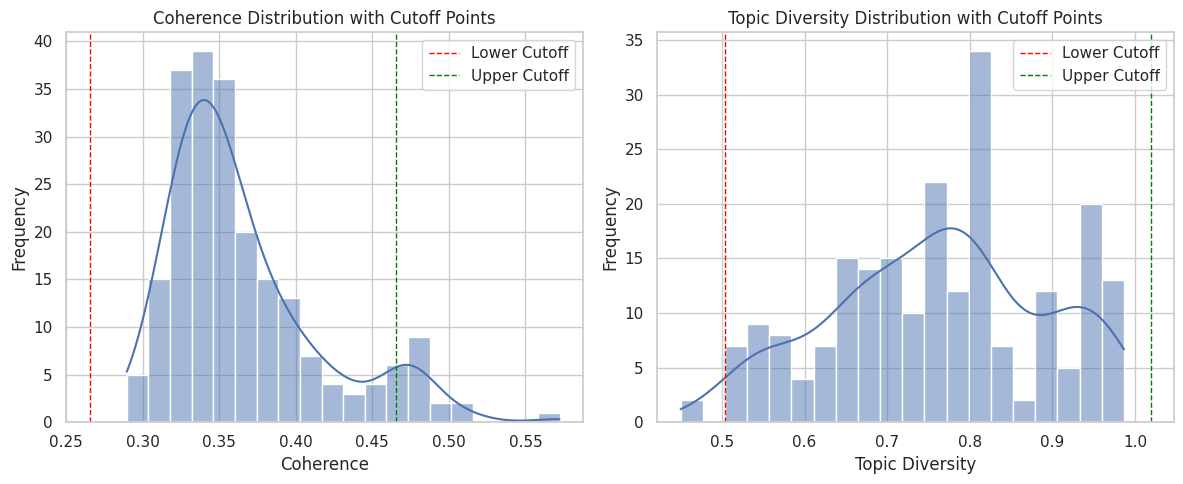

Data after removing outliers:
        Coherence  Topic_Diversity
count  196.000000       196.000000
mean     0.352838         0.758942
std      0.033360         0.129548
min      0.289532         0.506452
25%      0.329802         0.662834
50%      0.347134         0.757194
75%      0.371084         0.854167
max      0.458143         0.980000


In [5]:
# Data Cleaning (Removing Outliers)
# -----------------------------------------
# Explanation:
# We need to remove outliers from the data before analysis, specifically any runs where the metrics are beyond 2 standard deviations from the mean.
# Additionally, we remove runs where Topic Diversity is exactly 1, as this indicates a botched run.

# Remove runs where Topic Diversity or Coherence is exactly 1
df = df[df['Topic_Diversity'] < 1.0]
df = df[df['Coherence'] < 1.0]

# Compute the mean and standard deviation for Coherence and Topic Diversity
coherence_mean = df['Coherence'].mean()
coherence_std = df['Coherence'].std()
topic_diversity_mean = df['Topic_Diversity'].mean()
topic_diversity_std = df['Topic_Diversity'].std()

# Define the upper and lower bounds for acceptable values (within 2 standard deviations)
coherence_lower = coherence_mean - 2 * coherence_std
coherence_upper = coherence_mean + 2 * coherence_std
topic_diversity_lower = topic_diversity_mean - 2 * topic_diversity_std
topic_diversity_upper = topic_diversity_mean + 2 * topic_diversity_std

# Plot the distribution of Coherence with cutoff points
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Coherence'], bins=20, kde=True)
plt.axvline(coherence_lower, color='red', linestyle='dashed', linewidth=1, label='Lower Cutoff')
plt.axvline(coherence_upper, color='green', linestyle='dashed', linewidth=1, label='Upper Cutoff')
plt.title('Coherence Distribution with Cutoff Points')
plt.xlabel('Coherence')
plt.ylabel('Frequency')
plt.legend()

# Plot the distribution of Topic Diversity with cutoff points
plt.subplot(1, 2, 2)
sns.histplot(df['Topic_Diversity'], bins=20, kde=True)
plt.axvline(topic_diversity_lower, color='red', linestyle='dashed', linewidth=1, label='Lower Cutoff')
plt.axvline(topic_diversity_upper, color='green', linestyle='dashed', linewidth=1, label='Upper Cutoff')
plt.title('Topic Diversity Distribution with Cutoff Points')
plt.xlabel('Topic Diversity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Remove outliers from Coherence
df = df[(df['Coherence'] >= coherence_lower) & (df['Coherence'] <= coherence_upper)]

# Remove outliers from Topic Diversity
df = df[(df['Topic_Diversity'] >= topic_diversity_lower) & (df['Topic_Diversity'] <= topic_diversity_upper)]

# Reset the index after removing outliers
df = df.reset_index(drop=True)

print("Data after removing outliers:")
print(df[['Coherence', 'Topic_Diversity']].describe())


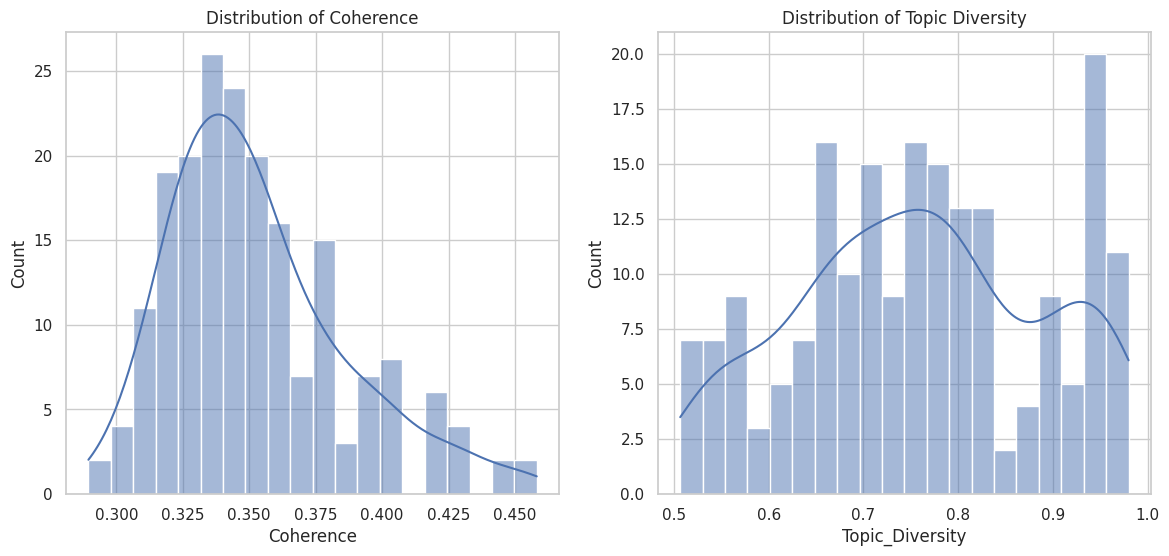

In [6]:
# Exploratory Data Analysis (EDA)
# ---------------------------------------
# Explanation:
# Visualize the distribution of Coherence and Topic Diversity to understand their ranges and variability.

# Histograms of the metrics
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Coherence'], bins=20, kde=True)
plt.title('Distribution of Coherence')

plt.subplot(1, 2, 2)
sns.histplot(df['Topic_Diversity'], bins=20, kde=True)
plt.title('Distribution of Topic Diversity')

plt.show()


# Metric Normalization

In [7]:
# Import the necessary library for Z-score normalization
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler for Z-score normalization
scaler = StandardScaler()

# Apply Z-score normalization to both Coherence and Topic Diversity columns
df[['Coherence_norm', 'Topic_Diversity_norm']] = scaler.fit_transform(df[['Coherence', 'Topic_Diversity']])

# Display the first few rows of the normalized metrics to verify
print(df[['Coherence_norm', 'Topic_Diversity_norm']].head())

   Coherence_norm  Topic_Diversity_norm
0        1.456810             -1.401605
1        2.903002              1.710748
2        2.374120             -0.456151
3        1.337438             -1.687343
4       -1.227076             -0.069204


# Metric Weighting and Combination

In [8]:
# Define weights for the metrics (customizable)
weight_coherence = 0.5  # You can adjust this weight based on importance
weight_topic_diversity = 0.5  # Adjust this weight as needed

# Compute the combined score based on weighted Z-score normalized metrics
df['Combined_Score'] = (weight_coherence * df['Coherence_norm']) + (weight_topic_diversity * df['Topic_Diversity_norm'])

# Display the first few rows to check combined score
print(df[['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']].head())

   Coherence_norm  Topic_Diversity_norm  Combined_Score
0        1.456810             -1.401605        0.027603
1        2.903002              1.710748        2.306875
2        2.374120             -0.456151        0.958985
3        1.337438             -1.687343       -0.174953
4       -1.227076             -0.069204       -0.648140


In [9]:
# Rank the DataFrame based on the combined score (higher is better)
df_sorted = df.sort_values(by='Combined_Score', ascending=False).reset_index(drop=True)

# Display the top 10 models based on the combined score
top_n = 10
print(f"Top {top_n} Models Based on Combined Score:")
display(df_sorted.head(top_n))

Top 10 Models Based on Combined Score:


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score
0,paraphrase-MiniLM-L6-v2,119,0.458143,0.966667,241,20,94,97,0.026139,2,19,0.001429,3.164751,1.607562,2.386157
1,paraphrase-mpnet-base-v2,3,0.449434,0.980000,234,25,100,62,0.061487,2,20,0.003023,2.903002,1.710748,2.306875
2,paraphrase-MiniLM-L6-v2,104,0.423820,0.975000,128,17,259,88,0.070500,2,3,0.009267,2.133234,1.672053,1.902643
3,ModernBERT-base-msmarco,92,0.452466,0.750000,130,10,468,12,0.021984,4,23,0.002951,2.994137,-0.069204,1.462466
4,paraphrase-MiniLM-L6-v2,88,0.404825,0.933333,69,33,127,31,0.092014,2,31,0.009536,1.562381,1.349598,1.455990
5,all-MiniLM-L12-v2,19,0.396078,0.966667,211,26,152,51,0.049710,3,43,0.006197,1.299509,1.607562,1.453536
6,all-MiniLM-L12-v2,101,0.392483,0.975000,127,26,128,68,0.066224,2,20,0.002257,1.191462,1.672053,1.431758
7,ModernBERT-base-msmarco,76,0.394231,0.933333,123,15,470,19,0.096390,2,20,0.002415,1.244002,1.349598,1.296800
8,ModernBERT-base-msmarco,3,0.447075,0.725217,234,25,100,62,0.061487,2,20,0.003023,2.832121,-0.260995,1.285563
9,paraphrase-mpnet-base-v2,15,0.384703,0.966667,213,22,127,80,0.006337,2,49,0.001590,0.957658,1.607562,1.282610


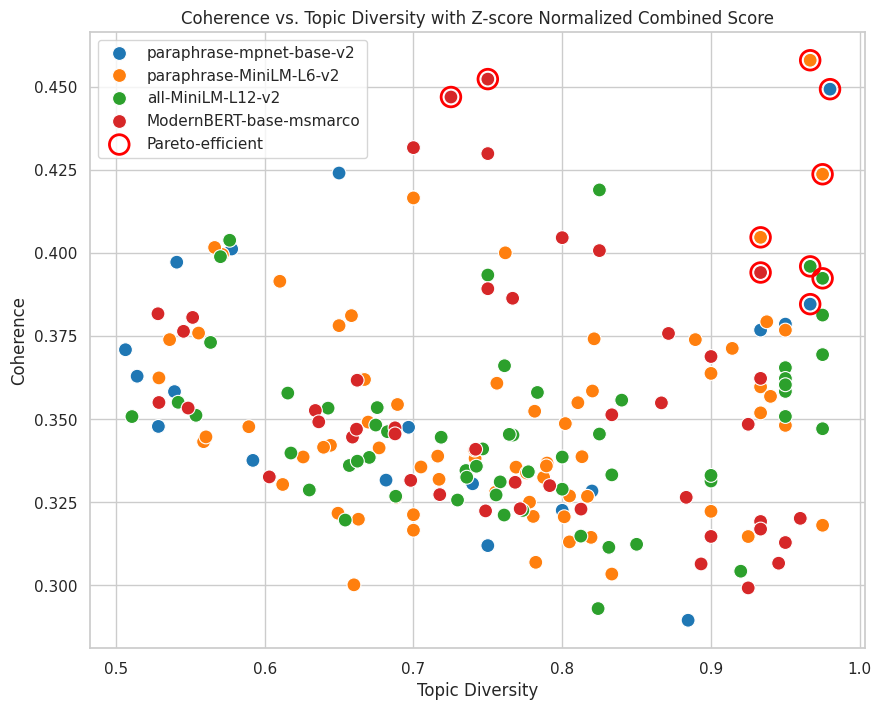

In [10]:
# Scatter plot of Coherence vs. Topic Diversity with hue based on Combined Score
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Embeddings_Model', palette='tab10', s=100)

# Highlight the top models
top_models = df_sorted.head(top_n)
plt.scatter(top_models['Topic_Diversity'], top_models['Coherence'], facecolors='none', edgecolors='red', s=200, linewidths=2, label='Pareto-efficient')

plt.title('Coherence vs. Topic Diversity with Z-score Normalized Combined Score')
plt.xlabel('Topic Diversity')
plt.ylabel('Coherence')
plt.legend()
plt.show()

# Pareto Front Analysis (Overall and Per Embedding Model)

In [12]:
# Import necessary libraries (if not already imported)
import numpy as np
import pandas as pd

# Function to identify Pareto-efficient points
def identify_pareto(df, metrics):
    """
    Identify Pareto-efficient points for given metrics.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data points.
    metrics (list): List of column names to use for Pareto analysis (in this case, Coherence_norm and Topic_Diversity_norm).

    Returns:
    pd.DataFrame: DataFrame with Pareto-efficient models flagged.
    """
    pareto_efficient = np.ones(df.shape[0], dtype=bool)  # Start with all True
    for i, row in df.iterrows():
        # If there are any other points that are strictly better, mark as not Pareto-efficient
        pareto_efficient[i] = not np.any(np.all(df[metrics].values >= row[metrics].values, axis=1) & np.any(df[metrics].values > row[metrics].values, axis=1))
    return pareto_efficient

# Assume df contains your models' performance data
# Identify Pareto-efficient points with equal weight for Coherence and Diversity
df['Pareto_Efficient'] = identify_pareto(df, ['Coherence_norm', 'Topic_Diversity_norm'])

# Select the Pareto-efficient models
pareto_efficient_models = df[df['Pareto_Efficient']]

# Select top 10 models based on Combined_Score (Equal weighting)
top_10_models_equal_weights = pareto_efficient_models.nlargest(10, 'Combined_Score')

# Save the top 10 models to Google Drive
top_10_models_equal_weights.to_csv('/content/drive/MyDrive/top_10_models_equal_weights.csv', index=False)

# Display the top 10 Pareto-efficient models
print(f"Top 10 Pareto-efficient Models with Equal Weights (Coherence and Diversity):")
display(top_10_models_equal_weights[['Embeddings_Model', 'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']])

Top 10 Pareto-efficient Models with Equal Weights (Coherence and Diversity):


,Embeddings_Model,Coherence_norm,Topic_Diversity_norm,Combined_Score
93,paraphrase-MiniLM-L6-v2,3.164751,1.607562,2.386157
1,paraphrase-mpnet-base-v2,2.903002,1.710748,2.306875


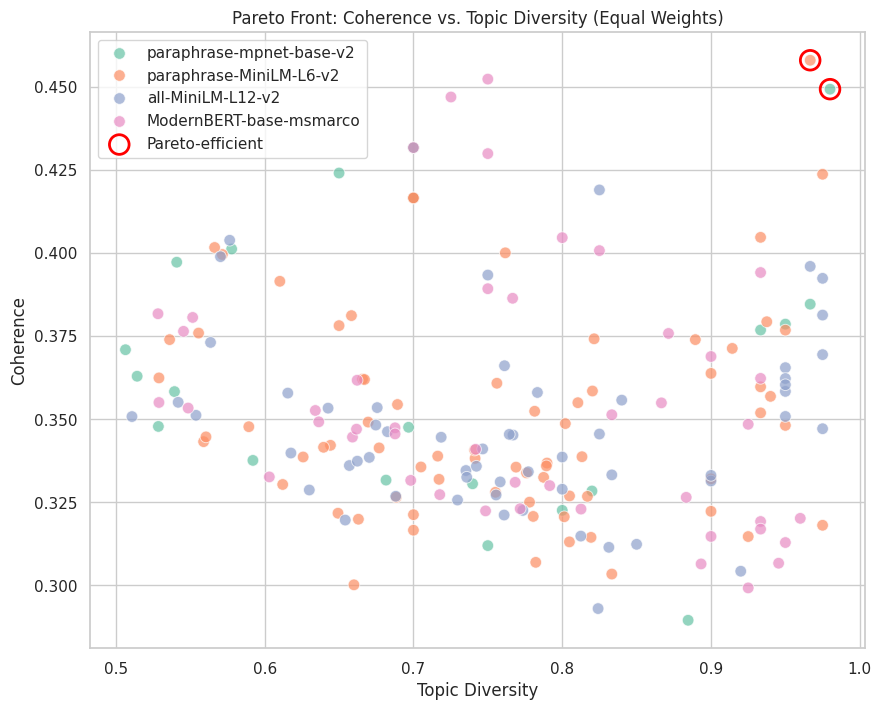

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Coherence vs. Topic Diversity, highlighting Pareto-efficient models
plt.figure(figsize=(10, 8))

# Adjust the point size to avoid overlap and make the plot more readable
# Reduce the size of all points and introduce transparency to deal with dense areas
sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Embeddings_Model',
                palette='Set2', s=70, alpha=0.7)

# Increase the size for Pareto-efficient models to highlight them clearly
pareto_models = df[df['Pareto_Efficient']]
plt.scatter(pareto_models['Topic_Diversity'], pareto_models['Coherence'],
            facecolors='none', edgecolors='red', s=200, linewidths=2, label='Pareto-efficient')

plt.title('Pareto Front: Coherence vs. Topic Diversity (Equal Weights)')
plt.xlabel('Topic Diversity')
plt.ylabel('Coherence')
plt.legend()

plt.show()

In [14]:
# Group the Pareto-efficient models by embedding model
pareto_grouped = pareto_efficient_models.groupby('Embeddings_Model').agg({
    'Coherence_norm': ['mean', 'std', 'count'],
    'Topic_Diversity_norm': ['mean', 'std', 'count'],
    'Combined_Score': ['mean', 'std', 'count']
}).reset_index()

# Rename the columns for better readability
pareto_grouped.columns = ['Embeddings_Model',
                          'Coherence_mean', 'Coherence_std', 'Coherence_count',
                          'Diversity_mean', 'Diversity_std', 'Diversity_count',
                          'Combined_mean', 'Combined_std', 'Combined_count']

# Display the performance of different embedding models
print("Performance of Embedding Models in Pareto-Efficient Models:")
display(pareto_grouped)

Performance of Embedding Models in Pareto-Efficient Models:


,Embeddings_Model,Coherence_mean,Coherence_std,Coherence_count,Diversity_mean,Diversity_std,Diversity_count,Combined_mean,Combined_std,Combined_count
0,paraphrase-MiniLM-L6-v2,3.164751,NaN,1,1.607562,NaN,1,2.386157,NaN,1
1,paraphrase-mpnet-base-v2,2.903002,NaN,1,1.710748,NaN,1,2.306875,NaN,1


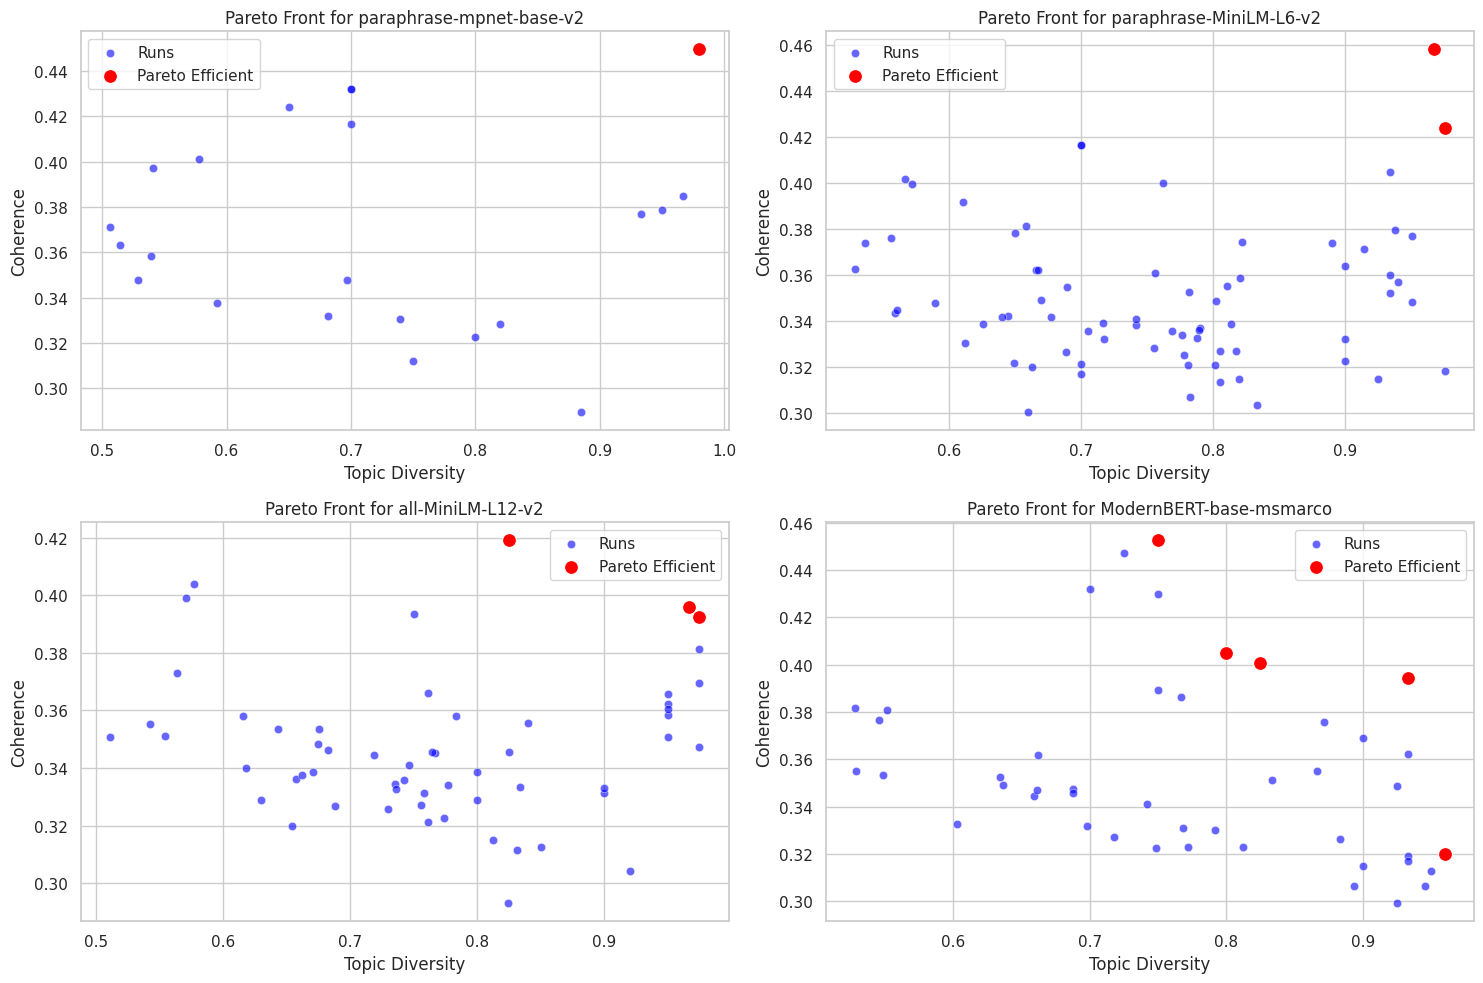

In [15]:
# Pareto Front Analysis (Overall and Per Embedding Model)
# ----------------------------------------------------------------
# Explanation:
# We will perform Pareto front analysis both across all models and separately for each embedding model.
# This helps in identifying optimal runs within each embedding model and understanding their trade-offs.

# Function to identify Pareto-efficient points
def identify_pareto(data):
    # Sort the data by Coherence in descending order
    sorted_data = data.sort_values(by='Coherence_norm', ascending=False)
    pareto_efficient = []
    current_max = -np.inf
    for index, row in sorted_data.iterrows():
        if row['Topic_Diversity_norm'] > current_max:
            pareto_efficient.append(True)
            current_max = row['Topic_Diversity_norm']
        else:
            pareto_efficient.append(False)
    # Assign the Pareto-efficient flag
    sorted_data['Pareto_Efficient'] = pareto_efficient
    # Return the DataFrame with Pareto_Efficient flag
    return sorted_data.sort_index()

# Apply Pareto front identification across all models
df['Pareto_Efficient_All'] = identify_pareto(df[['Coherence_norm', 'Topic_Diversity_norm']])['Pareto_Efficient']

# Now, apply Pareto front identification within each Embeddings_Model
df['Pareto_Efficient_PerModel'] = False  # Initialize the column

# Group the DataFrame by 'Embeddings_Model' and apply Pareto identification
for model_name, group in df.groupby('Embeddings_Model'):
    pareto_flags = identify_pareto(group[['Coherence_norm', 'Topic_Diversity_norm']])['Pareto_Efficient']
    df.loc[group.index, 'Pareto_Efficient_PerModel'] = pareto_flags

# Plotting Pareto Fronts

# Determine the number of unique embedding models
unique_models = df['Embeddings_Model'].unique()
num_models = len(unique_models)

# Define the grid size for plotting
cols = 2
rows = math.ceil(num_models / cols)

plt.figure(figsize=(15, 5 * rows))

for i, model_name in enumerate(unique_models, 1):
    plt.subplot(rows, cols, i)
    subset = df[df['Embeddings_Model'] == model_name]

    # Scatter plot of all runs
    sns.scatterplot(data=subset, x='Topic_Diversity', y='Coherence', label='Runs', color='blue', alpha=0.6)

    # Highlight Pareto-efficient runs
    pareto_subset = subset[subset['Pareto_Efficient_PerModel']]
    sns.scatterplot(data=pareto_subset, x='Topic_Diversity', y='Coherence', label='Pareto Efficient', color='red', s=100)

    plt.title(f'Pareto Front for {model_name}')
    plt.xlabel('Topic Diversity')
    plt.ylabel('Coherence')
    plt.legend()

plt.tight_layout()
plt.show()

# Pareto Front Analysis with New Combined Score with more Emphasis on Coherence

In [16]:
# Function to identify Pareto-efficient points
def identify_pareto(df, metrics):
    """
    Identify Pareto-efficient points for given metrics.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data points.
    metrics (list): List of column names to use for Pareto analysis (e.g., ['Coherence_norm', 'Topic_Diversity_norm']).

    Returns:
    np.array: Boolean array indicating whether each row is Pareto-efficient.
    """
    pareto_efficient = np.ones(df.shape[0], dtype=bool)  # Start with all True

    for i, row in df.iterrows():
        # If there are any other points that are strictly better, mark as not Pareto-efficient
        pareto_efficient[i] = not np.any(np.all(df[metrics].values >= row[metrics].values, axis=1) & np.any(df[metrics].values > row[metrics].values, axis=1))

    return pareto_efficient

In [17]:
# Define weights for coherence and topic diversity
weight_coherence = 0.7  # Higher weight for coherence
weight_topic_diversity = 0.3  # Lower weight for topic diversity

# Recalculate the combined score with new weights
df['Combined_Score'] = (weight_coherence * df['Coherence_norm']) + (weight_topic_diversity * df['Topic_Diversity_norm'])

# Rank the DataFrame based on the updated combined score (higher is better)
df_sorted = df.sort_values(by='Combined_Score', ascending=False).reset_index(drop=True)

# Display the top 10 models based on the updated combined score
top_n = 10
print(f"Top {top_n} Models Based on Updated Combined Score:")
display(df_sorted.head(top_n)[[
    'Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity',
    'bertopic__min_topic_size', 'bertopic__top_n_words', 'hdbscan__min_cluster_size',
    'hdbscan__min_samples', 'umap__min_dist', 'umap__n_components',
    'umap__n_neighbors', 'vectorizer__min_df', 'Coherence_norm',
    'Topic_Diversity_norm', 'Combined_Score', 'Pareto_Efficient',
    'Pareto_Efficient_All', 'Pareto_Efficient_PerModel'
]])

# Identify Pareto-efficient points based on the normalized coherence and diversity
df['Pareto_Efficient'] = identify_pareto(df, ['Coherence_norm', 'Topic_Diversity_norm'])

# Filter and display Pareto-efficient models with the updated combined score
pareto_efficient_models_updated = df[df['Pareto_Efficient']]
pareto_efficient_models_updated_with_names = pareto_efficient_models_updated[[
    'Embeddings_Model', 'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score'
]]

print(f"Number of Pareto-efficient Models (with Coherence priority): {pareto_efficient_models_updated_with_names.shape[0]}")
display(pareto_efficient_models_updated_with_names)


Top 10 Models Based on Updated Combined Score:


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score,Pareto_Efficient,Pareto_Efficient_All,Pareto_Efficient_PerModel
0,paraphrase-MiniLM-L6-v2,119,0.458143,0.966667,241,20,94,97,0.026139,2,19,0.001429,3.164751,1.607562,2.697595,True,True,True
1,paraphrase-mpnet-base-v2,3,0.449434,0.980000,234,25,100,62,0.061487,2,20,0.003023,2.903002,1.710748,2.545326,True,True,True
2,ModernBERT-base-msmarco,92,0.452466,0.750000,130,10,468,12,0.021984,4,23,0.002951,2.994137,-0.069204,2.075134,False,False,True
3,paraphrase-MiniLM-L6-v2,104,0.423820,0.975000,128,17,259,88,0.070500,2,3,0.009267,2.133234,1.672053,1.994880,False,False,True
4,ModernBERT-base-msmarco,3,0.447075,0.725217,234,25,100,62,0.061487,2,20,0.003023,2.832121,-0.260995,1.904186,False,False,False
5,ModernBERT-base-msmarco,84,0.430038,0.750000,75,14,377,18,0.025295,4,20,0.002971,2.320097,-0.069204,1.603307,False,False,False
6,all-MiniLM-L12-v2,66,0.419094,0.825000,228,27,105,22,0.011738,2,41,0.006573,1.991209,0.511215,1.547211,False,False,True
7,ModernBERT-base-msmarco,109,0.431835,0.700000,37,11,494,63,0.057924,4,25,0.001926,2.374120,-0.456151,1.525039,False,False,False
8,paraphrase-mpnet-base-v2,11,0.431835,0.700000,75,34,493,78,0.001153,3,43,0.002864,2.374120,-0.456151,1.525039,False,False,False
9,paraphrase-mpnet-base-v2,20,0.431835,0.700000,86,18,499,97,0.006231,2,50,0.006402,2.374120,-0.456151,1.525039,False,False,False


Number of Pareto-efficient Models (with Coherence priority): 2


,Embeddings_Model,Coherence_norm,Topic_Diversity_norm,Combined_Score
1,paraphrase-mpnet-base-v2,2.903002,1.710748,2.545326
93,paraphrase-MiniLM-L6-v2,3.164751,1.607562,2.697595


In [18]:
# Define new weights for coherence and topic diversity
weight_coherence = 0.7  # Higher weight for coherence
weight_topic_diversity = 0.3  # Lower weight for topic diversity

# Recalculate the combined score with new weights
df['Combined_Score'] = (weight_coherence * df['Coherence_norm']) + (weight_topic_diversity * df['Topic_Diversity_norm'])

# Identify Pareto-efficient points using the updated combined score
df['Pareto_Efficient'] = identify_pareto(df, ['Coherence_norm', 'Topic_Diversity_norm'])

# Display the new Pareto-efficient models with the adjusted combined score
pareto_efficient_models_updated = df[df['Pareto_Efficient']]
pareto_efficient_models_updated_with_names = pareto_efficient_models_updated[['Embeddings_Model', 'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']]

# Display updated Pareto-efficient models
print(f"Number of Pareto-efficient Models (with Coherence priority): {pareto_efficient_models_updated_with_names.shape[0]}")
display(pareto_efficient_models_updated_with_names)

# Rank the DataFrame based on the combined score (higher is better)
df_sorted = pareto_efficient_models_updated.sort_values(by='Combined_Score', ascending=False).reset_index(drop=True)

# Display the top 10 models based on the combined score
top_n = 10
print(f"Top {top_n} Models Based on Combined Score:")
display(df_sorted.head(top_n))

Number of Pareto-efficient Models (with Coherence priority): 2


,Embeddings_Model,Coherence_norm,Topic_Diversity_norm,Combined_Score
1,paraphrase-mpnet-base-v2,2.903002,1.710748,2.545326
93,paraphrase-MiniLM-L6-v2,3.164751,1.607562,2.697595


Top 10 Models Based on Combined Score:


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score,Pareto_Efficient,Pareto_Efficient_All,Pareto_Efficient_PerModel
0,paraphrase-MiniLM-L6-v2,119,0.458143,0.966667,241,20,94,97,0.026139,2,19,0.001429,3.164751,1.607562,2.697595,True,True,True
1,paraphrase-mpnet-base-v2,3,0.449434,0.980000,234,25,100,62,0.061487,2,20,0.003023,2.903002,1.710748,2.545326,True,True,True


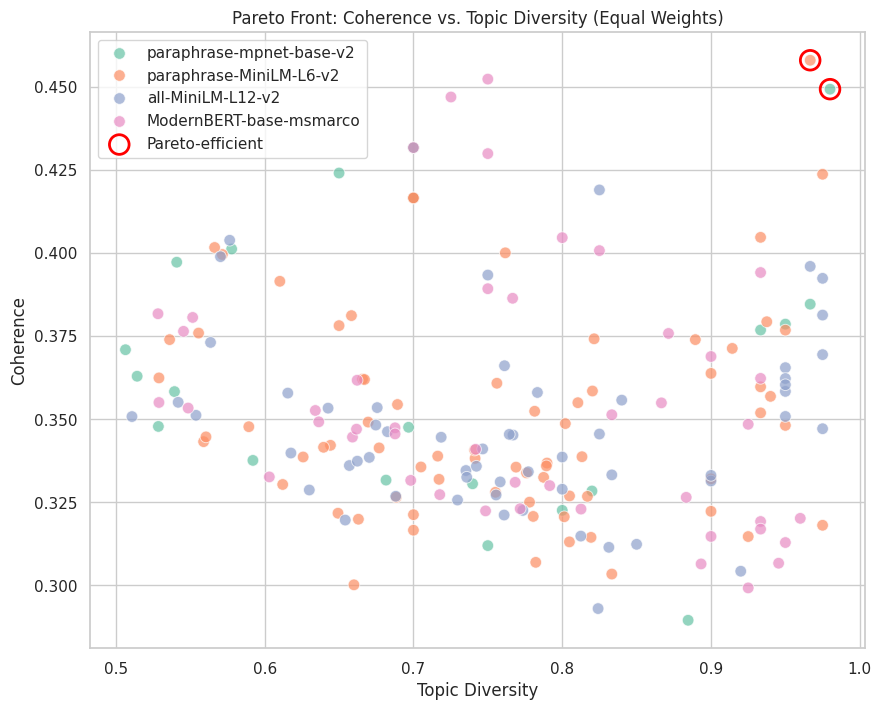

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Coherence vs. Topic Diversity, highlighting Pareto-efficient models
plt.figure(figsize=(10, 8))

# Adjust the point size to avoid overlap and make the plot more readable
# Reduce the size of all points and introduce transparency to deal with dense areas
sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Embeddings_Model',
                palette='Set2', s=70, alpha=0.7)

# Increase the size for Pareto-efficient models to highlight them clearly
pareto_models = df[df['Pareto_Efficient']]
plt.scatter(pareto_models['Topic_Diversity'], pareto_models['Coherence'],
            facecolors='none', edgecolors='red', s=200, linewidths=2, label='Pareto-efficient')

plt.title('Pareto Front: Coherence vs. Topic Diversity (Equal Weights)')
plt.xlabel('Topic Diversity')
plt.ylabel('Coherence')
plt.legend()

plt.show()

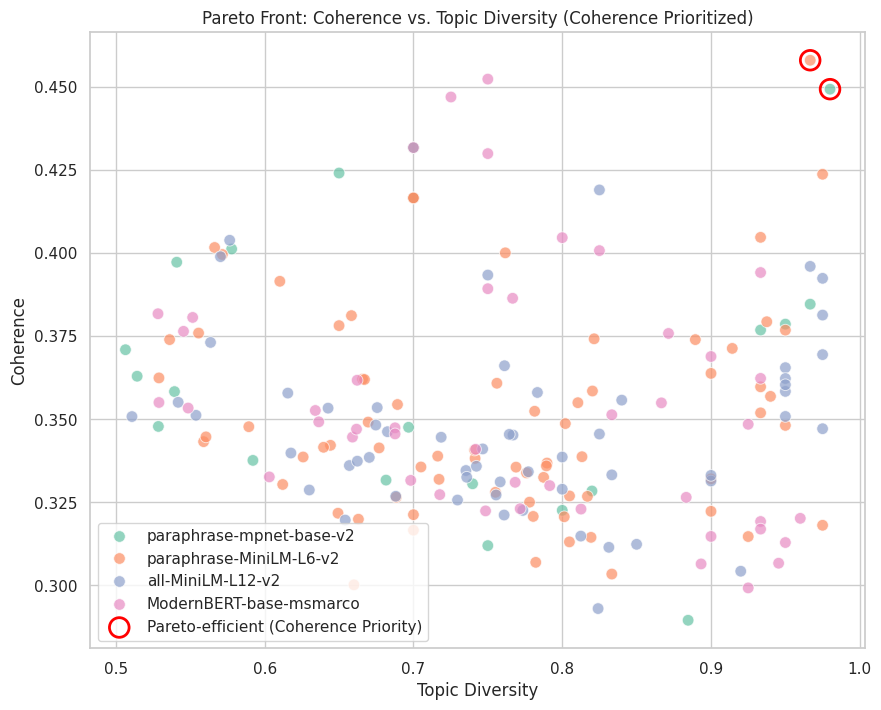

In [20]:
# Plot updated Pareto Front for all models
plt.figure(figsize=(10, 8))

# Scatter plot for all models
# Adjust the point size to avoid overlap and make the plot more readable
# Reduce the size of all points and introduce transparency to deal with dense areas
sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Embeddings_Model',
                palette='Set2', s=70, alpha=0.7)
# sns.scatterplot(data=df, x='Topic_Diversity', y='Coherence', hue='Combined_Score', palette='viridis', s=100)

# Increase the size for Pareto-efficient models to highlight them clearly
pareto_models = df[df['Pareto_Efficient']]
plt.scatter(pareto_models['Topic_Diversity'], pareto_models['Coherence'],
            facecolors='none', edgecolors='red', s=200, linewidths=2, label='Pareto-efficient (Coherence Priority)')


# Highlight Pareto-efficient models with updated weights
# pareto_models_updated = df[df['Pareto_Efficient']]
# plt.scatter(pareto_models_updated['Topic_Diversity'], pareto_models_updated['Coherence'], facecolors='none', edgecolors='red', s=200, linewidths=2, label='Pareto-efficient (Coherence Priority)')

plt.title('Pareto Front: Coherence vs. Topic Diversity (Coherence Prioritized)')
plt.xlabel('Topic Diversity')
plt.ylabel('Coherence')
plt.legend()
plt.show()

In [21]:
# Assuming df contains all performance metrics and hyperparameters
# Select the Pareto-efficient models
pareto_efficient_models = df[df['Pareto_Efficient']]

# Select the top 10 models based on Combined_Score (Coherence priority)
# Make sure to include hyperparameters along with other columns
top_10_models_with_hyperparameters = pareto_efficient_models.nlargest(10, 'Combined_Score')

# Save the top 10 models to Google Drive, including hyperparameters
top_10_models_with_hyperparameters.to_csv('/content/drive/MyDrive/top_10_models_coherence_priority_with_hyperparameters.csv', index=False)

# Display the top 10 Pareto-efficient models with hyperparameters
print(f"Top 10 Pareto-efficient Models with Coherence Priority (including Hyperparameters):")
display(top_10_models_with_hyperparameters)

Top 10 Pareto-efficient Models with Coherence Priority (including Hyperparameters):


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score,Pareto_Efficient,Pareto_Efficient_All,Pareto_Efficient_PerModel
93,paraphrase-MiniLM-L6-v2,119,0.458143,0.966667,241,20,94,97,0.026139,2,19,0.001429,3.164751,1.607562,2.697595,True,True,True
1,paraphrase-mpnet-base-v2,3,0.449434,0.980000,234,25,100,62,0.061487,2,20,0.003023,2.903002,1.710748,2.545326,True,True,True


In [ ]:
# Import necessary libraries
import pandas as pd

# Mount Google Drive to access the files
from google.colab import drive
drive.mount('/content/drive')

# Load the CSV with top 10 Pareto-efficient models with Coherence Priority
file_path_coherence_priority = '/content/drive/MyDrive/top_10_models_coherence_priority_with_hyperparameters.csv'
df_coherence_priority = pd.read_csv(file_path_coherence_priority)

# Load the CSV with top 10 Pareto-efficient models with Equal Weights (Coherence and Diversity)
file_path_equal_weights = '/content/drive/MyDrive/top_10_models_equal_weights.csv'
df_equal_weights = pd.read_csv(file_path_equal_weights)

# Display the head (first few rows) of each DataFrame
print("Top 10 Pareto-efficient Models with Coherence Priority:")
display(df_coherence_priority.head())

print("Top 10 Pareto-efficient Models with Equal Weights (Coherence and Diversity):")
display(df_equal_weights.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Top 10 Pareto-efficient Models with Coherence Priority:


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score,Pareto_Efficient,Pareto_Efficient_All,Pareto_Efficient_PerModel
0,all-MiniLM-L12-v2,66,0.577551,0.450000,102,30,281,72,0.005022,2,7,0.001504,4.151702,-2.885791,2.040454,True,True,True
1,paraphrase-mpnet-base-v2,14,0.469187,0.800000,63,22,500,72,0.077818,9,11,0.009372,2.043541,0.684541,1.635841,True,True,True
2,all-MiniLM-L12-v2,75,0.543105,0.466667,142,10,473,14,0.004634,5,15,0.001947,3.481574,-2.715775,1.622369,True,True,True
3,paraphrase-mpnet-base-v2,0,0.463245,0.820000,127,31,494,28,0.058341,10,11,0.007313,1.927944,0.888560,1.616129,True,True,True
4,paraphrase-MiniLM-L6-v2,19,0.425237,0.940000,64,27,143,32,0.085702,9,44,0.005932,1.188516,2.112674,1.465763,True,True,True


Top 10 Pareto-efficient Models with Equal Weights (Coherence and Diversity):


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score,Pareto_Efficient
0,paraphrase-MiniLM-L6-v2,19,0.425237,0.94,64,27,143,32,0.085702,9,44,0.005932,1.188516,2.112674,1.650595,True
1,paraphrase-mpnet-base-v2,0,0.463245,0.82,127,31,494,28,0.058341,10,11,0.007313,1.927944,0.888560,1.408252,True
2,paraphrase-mpnet-base-v2,14,0.469187,0.80,63,22,500,72,0.077818,9,11,0.009372,2.043541,0.684541,1.364041,True
3,paraphrase-MiniLM-L6-v2,28,0.354040,0.95,88,11,145,91,0.097223,10,45,0.008545,-0.196586,2.214684,1.009049,True
4,all-MiniLM-L12-v2,66,0.577551,0.45,102,30,281,72,0.005022,2,7,0.001504,4.151702,-2.885791,0.632956,True


# Hyperparameter Analysis

In [ ]:
# Check the column names in the loaded DataFrames
print("Columns in Coherence Priority DataFrame:")
print(df_coherence_priority.columns)

print("\nColumns in Equal Weights DataFrame:")
print(df_equal_weights.columns)

Columns in Coherence Priority DataFrame:
Index(['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity',
       'bertopic__min_topic_size', 'bertopic__top_n_words',
       'hdbscan__min_cluster_size', 'hdbscan__min_samples', 'umap__min_dist',
       'umap__n_components', 'umap__n_neighbors', 'vectorizer__min_df',
       'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score',
       'Pareto_Efficient', 'Pareto_Efficient_All',
       'Pareto_Efficient_PerModel'],
      dtype='object')

Columns in Equal Weights DataFrame:
Index(['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity',
       'bertopic__min_topic_size', 'bertopic__top_n_words',
       'hdbscan__min_cluster_size', 'hdbscan__min_samples', 'umap__min_dist',
       'umap__n_components', 'umap__n_neighbors', 'vectorizer__min_df',
       'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score',
       'Pareto_Efficient'],
      dtype='object')


In [ ]:
# Update the hyperparameters list based on the actual column names
hyperparameters = [
    'bertopic__min_topic_size', 'bertopic__top_n_words', 'hdbscan__min_cluster_size',
    'hdbscan__min_samples', 'umap__min_dist', 'umap__n_neighbors', 'vectorizer__min_df'
]

# The performance metrics are still Coherence_norm and Topic_Diversity_norm
performance_metrics = ['Coherence_norm', 'Topic_Diversity_norm']

# Filter the relevant columns from both DataFrames
df_coherence_priority_filtered = df_coherence_priority[hyperparameters + performance_metrics]
df_equal_weights_filtered = df_equal_weights[hyperparameters + performance_metrics]

# Calculate correlation for Coherence Priority
correlation_coherence_priority = df_coherence_priority_filtered.corr()

# Calculate correlation for Equal Weights
correlation_equal_weights = df_equal_weights_filtered.corr()

# Display the correlation matrices
print("Correlation Matrix for Coherence Priority Models:")
display(correlation_coherence_priority)

print("Correlation Matrix for Equal Weights Models:")
display(correlation_equal_weights)

Correlation Matrix for Coherence Priority Models:


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm
bertopic__min_topic_size,1.000000,-0.238503,0.553028,-0.617760,-0.606621,-0.331260,-0.110673,0.585395,-0.591078
bertopic__top_n_words,-0.238503,1.000000,-0.107463,-0.167174,-0.009822,-0.117898,-0.084259,0.145747,-0.023787
hdbscan__min_cluster_size,0.553028,-0.107463,1.000000,-0.399945,-0.275715,-0.796583,0.136964,0.562982,-0.450507
hdbscan__min_samples,-0.617760,-0.167174,-0.399945,1.000000,0.440867,0.083788,0.208264,-0.481557,0.407043
umap__min_dist,-0.606621,-0.009822,-0.275715,0.440867,1.000000,0.301191,0.709274,-0.527934,0.793502
umap__n_neighbors,-0.331260,-0.117898,-0.796583,0.083788,0.301191,1.000000,0.097362,-0.572619,0.497294
vectorizer__min_df,-0.110673,-0.084259,0.136964,0.208264,0.709274,0.097362,1.000000,-0.302096,0.619849
Coherence_norm,0.585395,0.145747,0.562982,-0.481557,-0.527934,-0.572619,-0.302096,1.000000,-0.892061
Topic_Diversity_norm,-0.591078,-0.023787,-0.450507,0.407043,0.793502,0.497294,0.619849,-0.892061,1.000000


Correlation Matrix for Equal Weights Models:


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm
bertopic__min_topic_size,1.000000,-0.238503,0.553028,-0.617760,-0.606621,-0.331260,-0.110673,0.585395,-0.591078
bertopic__top_n_words,-0.238503,1.000000,-0.107463,-0.167174,-0.009822,-0.117898,-0.084259,0.145747,-0.023787
hdbscan__min_cluster_size,0.553028,-0.107463,1.000000,-0.399945,-0.275715,-0.796583,0.136964,0.562982,-0.450507
hdbscan__min_samples,-0.617760,-0.167174,-0.399945,1.000000,0.440867,0.083788,0.208264,-0.481557,0.407043
umap__min_dist,-0.606621,-0.009822,-0.275715,0.440867,1.000000,0.301191,0.709274,-0.527934,0.793502
umap__n_neighbors,-0.331260,-0.117898,-0.796583,0.083788,0.301191,1.000000,0.097362,-0.572619,0.497294
vectorizer__min_df,-0.110673,-0.084259,0.136964,0.208264,0.709274,0.097362,1.000000,-0.302096,0.619849
Coherence_norm,0.585395,0.145747,0.562982,-0.481557,-0.527934,-0.572619,-0.302096,1.000000,-0.892061
Topic_Diversity_norm,-0.591078,-0.023787,-0.450507,0.407043,0.793502,0.497294,0.619849,-0.892061,1.000000


In [ ]:
# Descriptive statistics for hyperparameters in df_coherence_priority
descriptive_stats_priority = df_coherence_priority[hyperparameters].describe()
print("Descriptive Statistics for Hyperparameters (Coherence Priority):")
display(descriptive_stats_priority)

# Descriptive statistics for hyperparameters in df_equal_weights
descriptive_stats_equal_weights = df_equal_weights[hyperparameters].describe()
print("Descriptive Statistics for Hyperparameters (Equal Weights):")
display(descriptive_stats_equal_weights)

Descriptive Statistics for Hyperparameters (Coherence Priority):


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_neighbors,vectorizer__min_df
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,88.900000,21.900000,291.000000,55.300000,0.048776,27.600000,0.004997
std,33.321498,9.550451,147.127307,26.911584,0.035567,15.334783,0.003098
min,37.000000,10.000000,132.000000,14.000000,0.004634,7.000000,0.001174
25%,63.250000,12.250000,160.750000,33.250000,0.011041,12.000000,0.002018
50%,93.500000,23.000000,267.000000,57.500000,0.055678,31.000000,0.005369
75%,108.000000,29.250000,425.000000,72.000000,0.076378,41.250000,0.007272
max,142.000000,37.000000,500.000000,92.000000,0.097223,45.000000,0.009372


Descriptive Statistics for Hyperparameters (Equal Weights):


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_neighbors,vectorizer__min_df
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,88.900000,21.900000,291.000000,55.300000,0.048776,27.600000,0.004997
std,33.321498,9.550451,147.127307,26.911584,0.035567,15.334783,0.003098
min,37.000000,10.000000,132.000000,14.000000,0.004634,7.000000,0.001174
25%,63.250000,12.250000,160.750000,33.250000,0.011041,12.000000,0.002018
50%,93.500000,23.000000,267.000000,57.500000,0.055678,31.000000,0.005369
75%,108.000000,29.250000,425.000000,72.000000,0.076378,41.250000,0.007272
max,142.000000,37.000000,500.000000,92.000000,0.097223,45.000000,0.009372


<ipython-input-24-fc88e73d1639>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


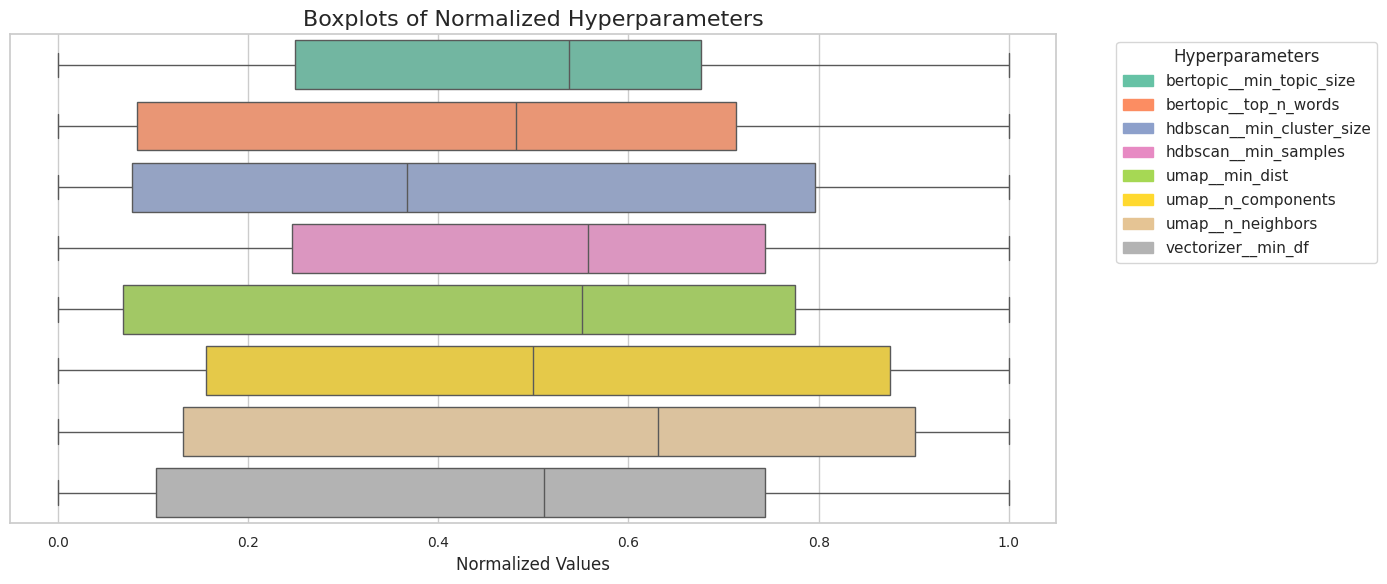

In [ ]:
# Define the list of hyperparameter column names
hyperparameters = [
    'bertopic__min_topic_size',
    'bertopic__top_n_words',
    'hdbscan__min_cluster_size',
    'hdbscan__min_samples',
    'umap__min_dist',
    'umap__n_components',
    'umap__n_neighbors',
    'vectorizer__min_df'
]

# Normalize hyperparameters using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

# Verify that all hyperparameters are present in the DataFrame
missing_cols = [col for col in hyperparameters if col not in df_coherence_priority.columns]
if missing_cols:
    print(f"The following hyperparameters are missing from df_coherence_priority: {missing_cols}")
else:
    # Proceed if all hyperparameters are present
    scaler = MinMaxScaler()
    df_normalized = df_coherence_priority.copy()
    df_normalized[hyperparameters] = scaler.fit_transform(df_coherence_priority[hyperparameters])

    # Melt the normalized DataFrame
    df_melted_norm = df_normalized.melt(
        value_vars=hyperparameters,
        var_name='Hyperparameter',
        value_name='Value'
    )

    # Create a color palette and map it to hyperparameters
    palette = sns.color_palette('Set2', n_colors=len(hyperparameters))
    color_mapping = dict(zip(hyperparameters, palette))

    # Create horizontal boxplots for each hyperparameter
    plt.figure(figsize=(14, 6))  # Wider figure
    ax = sns.boxplot(
        x='Value',
        y='Hyperparameter',
        data=df_melted_norm,
        orient='h',
        palette=color_mapping
    )

    # Customize the plot
    plt.title('Boxplots of Normalized Hyperparameters', fontsize=16)
    plt.xlabel('Normalized Values', fontsize=12)
    plt.ylabel('')  # Remove y-axis label if desired
    plt.grid(True)

    # Remove y-axis tick labels if desired
    plt.yticks([])

    # Adjust tick parameters for better visual aesthetics
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Calculate statistics
    stats = df_melted_norm.groupby('Hyperparameter')['Value'].agg(['mean', 'median', 'std'])

    # Get the positions of hyperparameters on the y-axis
    hyperparameter_positions = {label: index for index, label in enumerate(stats.index)}

    # Create legend handles for hyperparameters
    handles = [mpatches.Patch(color=color_mapping[param], label=param) for param in hyperparameters]

    # Create legend handles for mean and std lines
    mean_line = plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=2)
    std_line = plt.Line2D([0], [0], color='red', linestyle=':', linewidth=2)
    median_line = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2)

    # Create legends
    from matplotlib.legend import Legend

    # First, create a legend for the hyperparameters
    legend1 = ax.legend(handles=handles, title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust the plot to make room for the table
    plt.subplots_adjust(left=0.2, bottom=0.3)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np

# Function to calculate Cohen's d
def cohen_d(group1, group2):
    """
    Calculate Cohen's d for two groups.
    """
    diff_mean = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt(((np.std(group1, ddof=1) ** 2) + (np.std(group2, ddof=1) ** 2)) / 2)
    return diff_mean / pooled_std

# List of hyperparameters to test
hyperparameters = [
    'bertopic__min_topic_size',
    'bertopic__top_n_words',
    'hdbscan__min_cluster_size',
    'hdbscan__min_samples',
    'umap__min_dist',
    'umap__n_neighbors',
    'vectorizer__min_df'
]

# Performance metrics
performance_metrics = ['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']

# Dictionary to hold the results
results_priority = {'Hyperparameter': [], 'Metric': [], 'Correlation': [], 'p-value': [], 'Test_Type': [], 'Cohen_d': []}
results_equal_weights = {'Hyperparameter': [], 'Metric': [], 'Correlation': [], 'p-value': [], 'Test_Type': [], 'Cohen_d': []}

# Function to choose the right correlation test based on data distribution
def choose_test(df, parameter, metric):
    """
    Chooses between Pearson or Spearman correlation depending on the data distribution.
    If the data is normally distributed, use Pearson. Otherwise, use Spearman.
    """
    if df[parameter].skew() < 1 and df[parameter].skew() > -1:  # Use Pearson if the skewness is between -1 and 1
        corr, p_value = pearsonr(df[parameter], df[metric])
        test_type = "Pearson"
    else:
        corr, p_value = spearmanr(df[parameter], df[metric])
        test_type = "Spearman"

    return corr, p_value, test_type

# Function to calculate Cohen's d between two groups
def calculate_cohens_d(df, parameter, metric):
    """
    Split the dataframe into two groups based on the median of the parameter
    and calculate Cohen's d between the two groups for the specified metric.
    """
    median_value = df[parameter].median()
    group1 = df[df[parameter] <= median_value][metric]
    group2 = df[df[parameter] > median_value][metric]

    return cohen_d(group1, group2)

# Correlation and Cohen's d Analysis for Coherence Priority DataFrame
for param in hyperparameters:
    for metric in performance_metrics:
        # Perform the appropriate correlation test
        corr, p_value, test_type = choose_test(df_coherence_priority, param, metric)

        # Calculate Cohen's d
        cohens_d_value = calculate_cohens_d(df_coherence_priority, param, metric)

        # Store the results
        results_priority['Hyperparameter'].append(param)
        results_priority['Metric'].append(metric)
        results_priority['Correlation'].append(corr)
        results_priority['p-value'].append(p_value)
        results_priority['Test_Type'].append(test_type)
        results_priority['Cohen_d'].append(cohens_d_value)

# Correlation and Cohen's d Analysis for Equal Weights DataFrame
for param in hyperparameters:
    for metric in performance_metrics:
        # Perform the appropriate correlation test
        corr, p_value, test_type = choose_test(df_equal_weights, param, metric)

        # Calculate Cohen's d
        cohens_d_value = calculate_cohens_d(df_equal_weights, param, metric)

        # Store the results
        results_equal_weights['Hyperparameter'].append(param)
        results_equal_weights['Metric'].append(metric)
        results_equal_weights['Correlation'].append(corr)
        results_equal_weights['p-value'].append(p_value)
        results_equal_weights['Test_Type'].append(test_type)
        results_equal_weights['Cohen_d'].append(cohens_d_value)

# Convert the results into a DataFrame for easy viewing
correlation_results_priority = pd.DataFrame(results_priority)
correlation_results_equal_weights = pd.DataFrame(results_equal_weights)

# Display the results
print("Correlation and Cohen's d Results for Coherence Priority Models:")
display(correlation_results_priority)

print("Correlation and Cohen's d Results for Equal Weights Models:")
display(correlation_results_equal_weights)

# Save to a CSV for further analysis if needed
correlation_results_priority.to_csv('/content/drive/MyDrive/correlation_results_priority_with_cohens_d.csv', index=False)
correlation_results_equal_weights.to_csv('/content/drive/MyDrive/correlation_results_equal_weights_with_cohens_d.csv', index=False)

Correlation and Cohen's d Results for Coherence Priority Models:


,Hyperparameter,Metric,Correlation,p-value,Test_Type,Cohen_d
0,bertopic__min_topic_size,Coherence_norm,0.585395,0.075410,Pearson,-1.179971
1,bertopic__min_topic_size,Topic_Diversity_norm,-0.591078,0.071934,Pearson,1.623137
2,bertopic__min_topic_size,Combined_Score,0.501744,0.139510,Pearson,-0.750389
3,bertopic__top_n_words,Coherence_norm,0.145747,0.687865,Pearson,-0.566877
4,bertopic__top_n_words,Topic_Diversity_norm,-0.023787,0.947996,Pearson,0.396484
5,bertopic__top_n_words,Combined_Score,0.215445,0.549987,Pearson,-0.612537
6,hdbscan__min_cluster_size,Coherence_norm,0.562982,0.090180,Pearson,-1.064133
7,hdbscan__min_cluster_size,Topic_Diversity_norm,-0.450507,0.191347,Pearson,0.809358
8,hdbscan__min_cluster_size,Combined_Score,0.569070,0.085999,Pearson,-1.073321
9,hdbscan__min_samples,Coherence_norm,-0.481557,0.158764,Pearson,0.432597


Correlation and Cohen's d Results for Equal Weights Models:


,Hyperparameter,Metric,Correlation,p-value,Test_Type,Cohen_d
0,bertopic__min_topic_size,Coherence_norm,0.585395,0.075410,Pearson,-1.179971
1,bertopic__min_topic_size,Topic_Diversity_norm,-0.591078,0.071934,Pearson,1.623137
2,bertopic__min_topic_size,Combined_Score,-0.098488,0.786635,Pearson,0.664601
3,bertopic__top_n_words,Coherence_norm,0.145747,0.687865,Pearson,-0.566877
4,bertopic__top_n_words,Topic_Diversity_norm,-0.023787,0.947996,Pearson,0.396484
5,bertopic__top_n_words,Combined_Score,0.247351,0.490827,Pearson,-0.261204
6,hdbscan__min_cluster_size,Coherence_norm,0.562982,0.090180,Pearson,-1.064133
7,hdbscan__min_cluster_size,Topic_Diversity_norm,-0.450507,0.191347,Pearson,0.809358
8,hdbscan__min_cluster_size,Combined_Score,0.165178,0.648372,Pearson,-0.258745
9,hdbscan__min_samples,Coherence_norm,-0.481557,0.158764,Pearson,0.432597
